In [1]:
import torch
from shared.img_to_graph import img_to_graph
from _04_mnist_digits.graph_dataset import GraphDataset
import os

savedir = "_05_ct_images/data"
images = torch.load(savedir + "/augmented_images.pt")
labels = torch.load(savedir + "/augmented_labels.pt")
print(f"Loaded augmented images shape: {images.shape}")
print(f"Loaded augmented labels shape: {labels.shape}")

Loaded augmented images shape: torch.Size([10000, 224, 224])
Loaded augmented labels shape: torch.Size([10000])


In [2]:
if os.path.exists(savedir + "/dataset1000.pt"):
    print("Dataset already exists, skipping creation.")
    dataset = torch.load(savedir + "/dataset1000.pt", weights_only=False)
    print(type(dataset))
else:
    IMAGES_TO_SAVE = 1000
    dataset = GraphDataset(images[:IMAGES_TO_SAVE], labels[:IMAGES_TO_SAVE], use_weighted_edges=False)

    torch.save(dataset, savedir + "/dataset1000.pt")

Dataset already exists, skipping creation.
<class '_04_mnist_digits.graph_dataset.GraphDataset'>


In [3]:
print(dataset[0])

Data(x=[3487], edge_index=[2, 14327], y=3, edge_weight=[2])


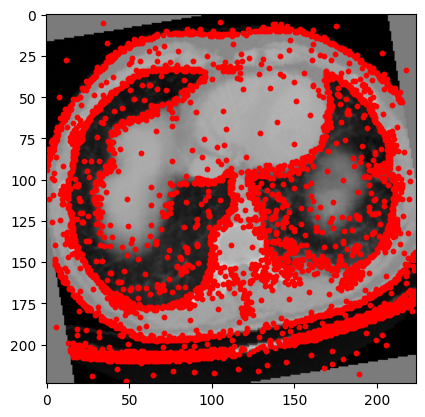

In [4]:
import matplotlib.pyplot as plt
img = images[0]
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
plt.imshow(img.numpy(), cmap='gray')
plt.scatter(dataset.centroids[0][:, 1].numpy(), dataset.centroids[0][:, 0].numpy(), c='red', s=10, label='Centroids')

In [5]:
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

class GraphDatasetWithCentroids(Dataset):
    def __init__(self, Xs, centroids, edge_indices=None, edge_weights=None, labels=None):
        super().__init__()
        self.Xs = Xs
        self.centroids = centroids
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.labels = labels
    
    def len(self):
        return len(self.Xs)
    
    def get(self, idx):
        return Data(x=torch.cat((self.Xs[idx].unsqueeze(-1), self.centroids[idx]), dim=1), # (Nnodes, 1) + (Nnodes, 2)
        edge_index=self.edge_indices[idx].T, # (2, Nedges)
        edge_weight=self.edge_weights[idx],
        y=self.labels[idx])

new_dataset = GraphDatasetWithCentroids(dataset.Xs, dataset.centroids, dataset.edge_indices, dataset.edge_weights, dataset.labels)

In [6]:
dataset = new_dataset

example_x = dataset[0].x
if example_x.dim() == 2:
    num_features = example_x.shape[1]  # Set the number of features
else:
    num_features = 1

num_classes = len(set(dataset.labels.tolist()))  # Set the number of classes

datasets = {}
loaders = {}

for split, dataset in zip(["train", "val", "test"], torch.utils.data.random_split(dataset, (0.7, 0.15, 0.15))):
    datasets[split] = dataset
    loaders[split] = DataLoader(dataset, batch_size=(32 if split == "train" else len(dataset)), shuffle=(split == "train"))

In [7]:
print(datasets["train"][0])

Data(x=[2277, 3], edge_index=[2, 9165], y=3, edge_weight=[2])


In [11]:
from torch_geometric.nn import EdgeCNN, summary
from shared.models.GNNClassifier import GNNClassifier
import torch_geometric.nn as nn
from shared.training import train_classifier


class Classifier(GNNClassifier):
    def __init__(self, in_channels, num_classes, num_layers, hidden_channels, **kwargs):
        super().__init__(num_node_features=in_channels,
                        num_classes=num_classes,
                        hidden_ch=hidden_channels,)
        self.edgecnn = EdgeCNN(in_channels=in_channels,
                               num_layers=num_layers,
                               hidden_channels=hidden_channels,
                               )

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.edgecnn(x, edge_index, edge_weight=edge_weight)

        # Use PyTorch Geometric's global_max_pool which handles batching correctly
        if batch is None:
            # If no batch info, assume single graph
            x = torch.max(x, dim=0, keepdim=True).values
        else:
            # Proper batched global pooling
            x = nn.global_max_pool(x, batch)
        
        x = self.mlp(x)
        return x
    
    def get_model_inputs_from_batch(self, batch):
        return 

model = Classifier(in_channels=num_features,
                num_classes=10,
                num_layers=3,
                hidden_channels=128,)

model.get_model_inputs_from_batch = lambda batch: (batch.x, batch.edge_index, batch.batch)


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in loaders["train"]:
    print(batch)
    print([x.shape for x in model.get_model_inputs_from_batch(batch)])
    print(summary(model, *model.get_model_inputs_from_batch(batch)))
    break

print(model)

DataBatch(x=[91060, 3], edge_index=[2, 376498], y=[32], edge_weight=[64], batch=[91060], ptr=[33])
[torch.Size([91060, 3]), torch.Size([2, 376498]), torch.Size([91060])]
+----------------------------+----------------------------------+----------------+----------+
| Layer                      | Input Shape                      | Output Shape   | #Param   |
|----------------------------+----------------------------------+----------------+----------|
| Classifier                 | [91060, 3], [2, 376498], [91060] | [32, 10]       | 184,202  |
| ├─(convolutions)ModuleList | --                               | --             | 66,688   |
| │    └─(0)GraphConv        | --                               | --             | 896      |
| │    └─(1)GraphConv        | --                               | --             | 32,896   |
| │    └─(2)GraphConv        | --                               | --             | 32,896   |
| ├─(mlp)Sequential          | [32, 128]                        | [32, 10]    

In [12]:
overall_train_acc, overall_val_acc = train_classifier(N_epochs=25,
                                                    model=model,
                                                    train_dataloader=loaders["train"],
                                                    val_dataloader=loaders["val"],
                                                    loss=loss,
                                                    optimizer=optimizer,
                                                    )

Epoch    T Loss  T Acc  V Loss  V Acc

1/25     1.509   0.310   1.409   0.293
2/25     1.378   0.335   1.315   0.467
3/25     1.354   0.351   1.303   0.353
4/25     1.321   0.387   1.256   0.393
5/25     1.281   0.398   1.344   0.227
6/25     1.267   0.408   1.251   0.347
7/25     1.262   0.417   1.205   0.467
8/25     1.232   0.447   1.204   0.427
9/25     1.208   0.476   1.140   0.500
10/25    1.149   0.467   1.152   0.507
11/25    1.155   0.467   1.304   0.347
12/25    1.091   0.510   1.201   0.440
13/25    1.109   0.495   1.294   0.347
14/25    1.090   0.524   1.149   0.480
15/25    1.065   0.530   1.284   0.373
16/25    1.062   0.532   1.162   0.467
17/25    1.063   0.529   1.181   0.433
18/25    0.933   0.603   1.096   0.507
19/25    0.861   0.637   1.190   0.433
20/25    0.957   0.576   1.468   0.327
21/25    0.922   0.579   1.122   0.547
22/25    0.748   0.710   1.266   0.400
23/25    0.765   0.694   1.340   0.353
24/25    0.951   0.603   1.285   0.387
25/25    0.668   0.741   

In [13]:
torch.save(model.state_dict(), "_04_mnist_digits/models/EdgeCNN_unweighted_with_centroids.pt")

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for batch in loaders["test"]:
    y_true = batch.y
    y_pred = model(*model.get_model_inputs_from_batch(batch)).argmax(dim=1)
    print(classification_report(y_true, y_pred, digits=4, target_names=[str(i) for i in range(10)]))

    mat = confusion_matrix(y_true, y_pred)

ValueError: Number of classes, 4, does not match size of target_names, 10. Try specifying the labels parameter

: 

Text(0.5, 58.7222222222222, 'Predicted')

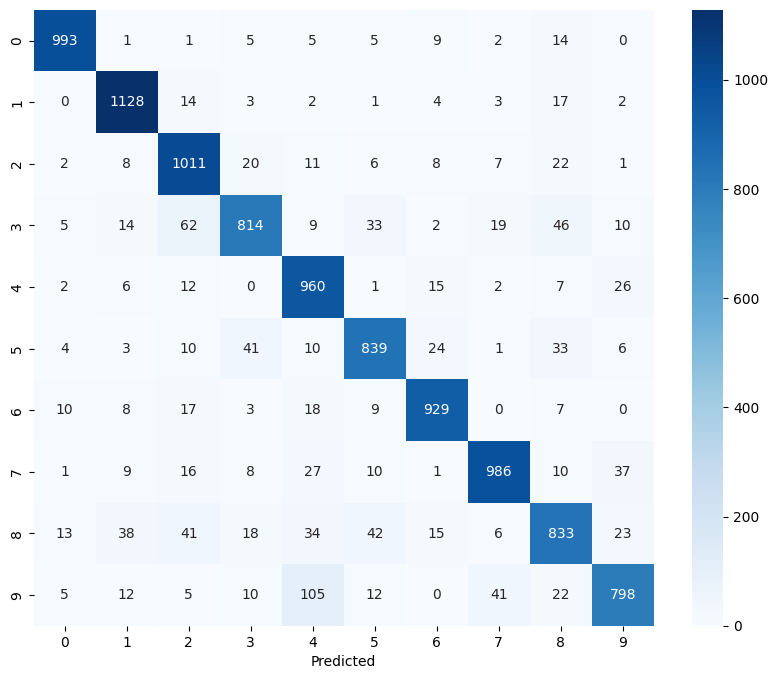

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')

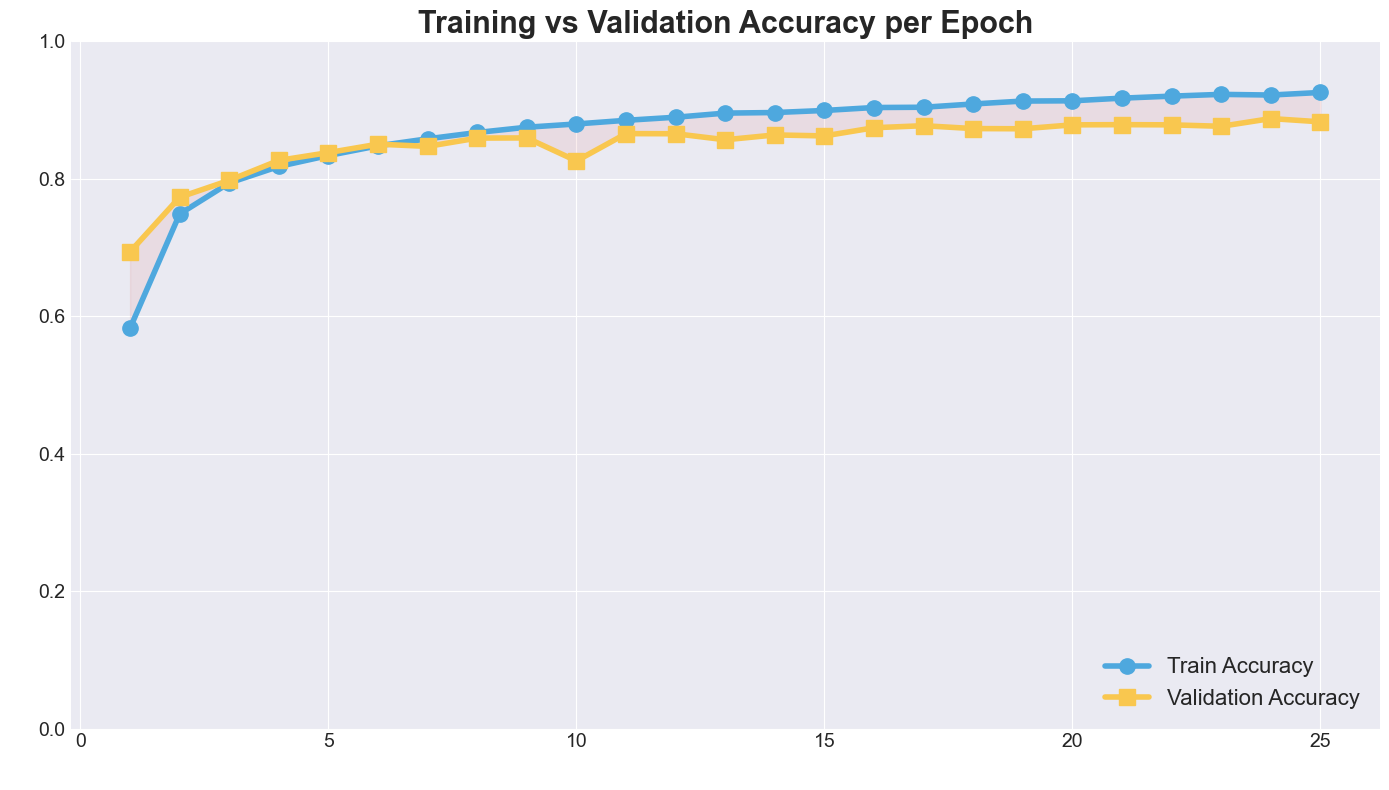

In [ ]:
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

epochs = range(1, len(overall_train_acc) + 1)

plt.plot(epochs, overall_train_acc, label='Train Accuracy', linewidth=4, marker='o', color='#4ea8de', markersize=11)
plt.plot(epochs, overall_val_acc, label='Validation Accuracy', linewidth=4, marker='s', color='#f9c74f', markersize=11)

# Highlight the area between curves for clarity
plt.fill_between(epochs, overall_train_acc, overall_val_acc, color="#e08888", alpha=0.15)

plt.xlabel('Epoch', fontsize=18, color='white', weight='bold')
plt.ylabel('Accuracy', fontsize=18, color='white', weight='bold')
plt.title('Training vs Validation Accuracy per Epoch', fontsize=22, weight='bold')
plt.legend(loc='lower right', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()